In [3]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import scipy.optimize as spop

from datetime import datetime, timedelta
import os
import asyncio

from binance.client import AsyncClient, HistoricalKlinesType

<h2 style="color: orange">Binance_Batch_Klines_Downloader</h2>

In [3]:
client = await AsyncClient.create()

class Binance_Batch_Klines_Downloader:
  def __init__(self, days_back = 2, interval = "1h", klines_types=[HistoricalKlinesType.FUTURES], rate_limit_ps=2):
    self.days_back = days_back
    self.start = str(datetime.utcnow() - timedelta(days = self.days_back))
    
    self.interval = interval
    self.klines_types = klines_types
    self.rate_limit_ps = rate_limit_ps
    
  def _bars_to_df(self, bars):
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit = "ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume",
                  "Close Time", "Quote Asset Volume", "Number of Trades",
                  "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace = True)
    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors = "coerce")
        
    return df
  
  async def _get_symbols(self, klines_type):
    exchange_info = None
    if klines_type == HistoricalKlinesType.FUTURES:
      exchange_info = await client.futures_exchange_info()
    if klines_type == HistoricalKlinesType.SPOT:
      exchange_info = await client.get_exchange_info()
    
    if exchange_info is not None:
      return list(map(lambda x: x['symbol'], exchange_info['symbols']))
  
  async def _download_kline_type(self, klines_type):
    symbols = await self._get_symbols(klines_type)
    if not len(symbols):
      return
    
    new_dir = "Binance_Historical_%s_%s_%i_days_%s" % (self.interval, klines_type.name, self.days_back, str(datetime.utcnow().replace(microsecond=0).isoformat()))
    os.mkdir(new_dir)
    
    chunks = []
    for idx, _ in enumerate(symbols):
      if idx % self.rate_limit_ps == 0:
        symbols_chunk = symbols[idx:idx+self.rate_limit_ps]
        futures_chunk = []
        
        for symbol in symbols_chunk:
          futures_chunk.append(client.get_historical_klines(symbol = symbol, interval = self.interval,
                                        start_str = self.start, end_str = None, limit = 1000, klines_type=klines_type))
          
        chunks.append(futures_chunk)
        
    for index, chunk in enumerate(chunks):
      print("Fetching data for ↓ %s %s" % (klines_type.name, self.interval), "%i / %i" % (index, len(chunks)))
      results = await asyncio.gather(*chunk)
      
      for i, bars in enumerate(results):
        print(symbols[index*self.rate_limit_ps+i])
        try:
          df = self._bars_to_df(bars)
          df.to_csv("%s/%s_%s_%s.csv" % (new_dir, symbols[index*self.rate_limit_ps+i], klines_type.name, self.interval))
        except:
          # print("raw: ", bars)
          print("Couldn't construct DataFrame from raw data for %s" % symbols[index*self.rate_limit_ps+i])
          
  async def download(self):
    for type in self.klines_types:
      print(type)
      await self._download_kline_type(type)

<h2 style="color: orange">DEMO</h2>

In [4]:
downloader = Binance_Batch_Klines_Downloader(days_back=20, interval="15m", klines_types=[HistoricalKlinesType.FUTURES], rate_limit_ps=7)

In [5]:
await downloader.download()

HistoricalKlinesType.FUTURES
Fetching data for ↓ FUTURES 15m 0 / 25
BTCUSDT
ETHUSDT
BCHUSDT
XRPUSDT
EOSUSDT
LTCUSDT
TRXUSDT
Fetching data for ↓ FUTURES 15m 1 / 25
ETCUSDT
LINKUSDT
XLMUSDT
ADAUSDT
XMRUSDT
DASHUSDT
ZECUSDT
Fetching data for ↓ FUTURES 15m 2 / 25
XTZUSDT
BNBUSDT
ATOMUSDT
ONTUSDT
IOTAUSDT
BATUSDT
VETUSDT
Fetching data for ↓ FUTURES 15m 3 / 25
NEOUSDT
QTUMUSDT
IOSTUSDT
THETAUSDT
ALGOUSDT
ZILUSDT
KNCUSDT
Fetching data for ↓ FUTURES 15m 4 / 25
ZRXUSDT
COMPUSDT
OMGUSDT
DOGEUSDT
SXPUSDT
KAVAUSDT
BANDUSDT
Fetching data for ↓ FUTURES 15m 5 / 25
RLCUSDT
WAVESUSDT
MKRUSDT
SNXUSDT
DOTUSDT
DEFIUSDT
YFIUSDT
Fetching data for ↓ FUTURES 15m 6 / 25
BALUSDT
CRVUSDT
TRBUSDT
RUNEUSDT
SUSHIUSDT
SRMUSDT
EGLDUSDT
Fetching data for ↓ FUTURES 15m 7 / 25
SOLUSDT
ICXUSDT
STORJUSDT
BLZUSDT
UNIUSDT
AVAXUSDT
FTMUSDT
Fetching data for ↓ FUTURES 15m 8 / 25
HNTUSDT
ENJUSDT
FLMUSDT
TOMOUSDT
RENUSDT
KSMUSDT
NEARUSDT
Fetching data for ↓ FUTURES 15m 9 / 25
AAVEUSDT
FILUSDT
RSRUSDT
LRCUSDT
MATICUSDT
OCEANUSDT

<h2 style="color:purple;">Kalman Filters</h2>

In [14]:
from pykalman import KalmanFilter
from math import sqrt

In [15]:
def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means
# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    spread_lag2 = sm.add_constant(spread_lag)
    model = sm.OLS(spread_ret,spread_lag2)
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

<h2 style="color:lime;">Coint_Analyzer</h2>

In [130]:
class Data_Digger:
  def __init__(self, dir_paths=["Binance_Historical_15m_FUTURES_20_days_2022-07-14T12:00:43"], observations_low_pass = 0):
    self.dir_paths = dir_paths
    self.observations_low_pass = observations_low_pass
    
    self.df = None
    self.corr_pairs = None
    self.coint_pairs = None
    self.corr_coint_pairs = None
    
  def process_raw_data(self, dir_paths=None):
    if dir_paths is not None:
      self.dir_paths = dir_paths
    self._closings_csv_to_df()
    self._raw_to_processed()
    self.get_trading_pairs()
  
  def _closings_csv_to_df(self):
    # reading Close values and merging to one DF
    df_closings = pd.DataFrame()
    
    for path in self.dir_paths:
      with os.scandir('raw_data/%s' % path) as entries:
          for entry in entries:
            instrument = "_".join(entry.name.split("_")[0:2])
            df = pd.read_csv('raw_data/%s/%s' % (path, entry.name), index_col="Date")
            df = df[["Close"]].copy()
            df.columns = [instrument]
            df_closings = pd.concat([df_closings, df], axis=1)
    
    # filtering data based on amount of observations in DF
    df_observation_num = pd.DataFrame(columns=["observations"])
    for column in df_closings.columns:
      df_observation_num.loc[column] = len(df_closings[column].dropna())

    drop_columns = []
    for _, row in df_observation_num.iterrows():
      if row.observations < self.observations_low_pass: # arbitrarily selected value based on bottom values from df_observation_num
        drop_columns.append(row.name)
        
    # removing outliers from the original DF
    df_closings.drop(columns=drop_columns, inplace=True)

    # cleaning DF
    df_closings.dropna(inplace=True)
            
    self.df = df_closings
    
  def _raw_to_processed(self):
    # CORRELATION
    if self.df is None:
      return
    
    matrix = self.df.pct_change().corr(method ='pearson')
    matrix.to_excel("processed_data/corr_matrix_temp_%s.xlsx" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
    
    au_corr = matrix.corr().unstack()
    labels_to_drop = self._get_redundant_corr_pairs(matrix)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    au_corr.dropna(inplace=True)
    
    indexes = []
    values = []
    for idx in au_corr.index:
        indexes.append("%s-%s" % (idx[0], idx[1]))
        values.append(au_corr[idx])
    corr_pairs_df = pd.DataFrame(index=indexes, data=values)
    
    self.corr_pairs = corr_pairs_df
    try:
        corr_pairs_df.to_csv("processed_data/corr_pairs__tem%s.csv" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
    except:
      print("Couldn't save pairs to temp files")
      
    # COINTEGRATION 
    _, coint_pairs = self._find_cointegrated_pairs(self.df)
    self.coint_pairs = coint_pairs
    
    
  def _get_redundant_corr_pairs(self, df_corr_matrix):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df_corr_matrix.columns
    for i in range(0, df_corr_matrix.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop
    
  def _find_cointegrated_pairs(self, df):
    n = df.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = df.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            print("Performing coint test %s %s %s" % (j, i, n))
            
            result = coint(df[keys[i]], df[keys[j]])
            pvalue_matrix[i, j] = result[1]
            
            # testing for spread stationarity
            if result[1] < 0.05:
              state_means = KalmanFilterRegression(KalmanFilterAverage(df[keys[i]]),KalmanFilterAverage(df[keys[j]]))
              hedge_ratio = - state_means[:,0]
              spread = df[keys[j]] + (df[keys[i]] * hedge_ratio)
              result_adf = adfuller(spread)
              
              if result_adf[1] < 0.01 and result_adf[0] < result_adf[4]["1%"]:
                # is mean reverting
                hurst = self._get_hurst_exponent(np.array(spread))
                if hurst <= 0.5:
                  pairs.append((keys[i], keys[j], result[1], result_adf[0], hurst))
    try:
        indexes = []
        adf = []
        hurst = []
        for row in pairs:
            indexes.append("%s-%s" % (row[0], row[1]))
            adf.append(row[3])
            hurst.append(row[4])
            
        coint_pairs_df = pd.DataFrame(index=indexes)
        coint_pairs_df['adf'] = adf
        coint_pairs_df['hurst'] = hurst
        coint_pairs_df.sort_values(ascending=True, by="adf")
        coint_pairs_df.to_csv("processed_data/coint_pairs_temp%s.csv" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
        
        pv_val_df = pd.DataFrame(pvalue_matrix)
        pv_val_df.columns = df.columns
        pv_val_df.index = df.columns
        pv_val_df.to_excel("processed_data/coint_matrix_temp_%s.xlsx" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
    except:
       print("Couldn't save pairs to temp files") 
    return pvalue_matrix, coint_pairs_df
  
  def _get_hurst_exponent(self, time_series):
    """Returns the Hurst Exponent of the time series vector ts"""
    # Create the range of lag values
    lags = range(2, 20)
    # Calculate the array of the variances of the lagged differences
    tau = [np.sqrt(np.std(np.subtract(time_series[lag:], time_series[:-lag]))) for lag in lags]
    # Use a linear fit to estimate the Hurst Exponent
    poly = np.polyfit(np.log(lags), np.log(tau), 1)
    # Return the Hurst exponent from the polyfit output
    return poly[0]*2.0
  
  
    
  def get_trading_pairs(self, h_pass = 0.95, corr_path = None, coint_path = None):
    df_corr = None
    df_coint = None
    if corr_path is not None and coint_path is not None:
      df_corr = pd.read_csv(corr_path)
      df_coint = pd.read_csv(coint_path)
    elif self.corr_pairs is not None and self.coint_pairs is not None:
      df_corr = self.corr_pairs.copy()
      df_coint = self.coint_pairs.copy()
      
    if df_corr is None or df_coint is None:
      return
    
    df_hi_corr = df_corr.loc[df_corr[0]>h_pass]
    df_corr_coint_pairs = pd.DataFrame(columns=["corr", "adf", "hurst"])
    for idx in df_hi_corr.index:
      if idx in df_coint.index:
        df_corr_coint_pairs.loc[idx] = [df_hi_corr.loc[idx][0], df_coint.loc[idx][0], df_coint.loc[idx][1]]
        
    self.corr_coint_pairs = df_corr_coint_pairs
    try:
      df_corr_coint_pairs.to_csv("processed_data/corr_coint_pairs_temp_%s.csv" % str(datetime.utcnow().replace(microsecond=0).isoformat()))
    except:
      print("Data couldn't be stored in a static file.")
    return df_corr_coint_pairs
  

<h2 style="color:lime;">DEMO</h2>

In [4]:
analyzer = Data_Digger()

NameError: name 'Data_Digger' is not defined

In [ ]:
analyzer.process_raw_data()

In [132]:
analyzer.coint_pairs

In [134]:
analyzer.get_trading_pairs()

,corr,adf,hurst
ETHBUSD_FUTURES-ETHUSDT_FUTURES,0.999983,-8.933520,0.018376
BTCBUSD_FUTURES-BTCUSDT_FUTURES,0.999955,-10.880112,-0.022285
BNBUSDT_FUTURES-BNBBUSD_FUTURES,0.999939,-10.994286,0.129904
GMTUSDT_FUTURES-GMTBUSD_FUTURES,0.999904,-15.920310,0.405155
AVAXBUSD_FUTURES-AVAXUSDT_FUTURES,0.999863,-8.761420,0.299353
...,...,...,...
WAVESBUSD_FUTURES-IMXUSDT_FUTURES,0.953428,-4.134486,0.270739
CTKUSDT_FUTURES-GMTBUSD_FUTURES,0.953067,-10.398868,0.422835
CTKUSDT_FUTURES-GMTUSDT_FUTURES,0.952435,-10.462654,0.422454
UNIUSDT_FUTURES-SNXUSDT_FUTURES,0.951718,-10.225884,0.380812


<h2 style="color:salmon">Backtester</h2>

In [38]:
class Backtester:
  def __init__(self, dir_name, data_interval, pair, tc):
    self.dir_name = dir_name
    self.data_interval = data_interval
    self.pair = pair
    self.tc = tc
    
    self.results = None
    self.data = None
    self.tp_year = None
    
    self._get_data()
    
    
  def __repr__(self):
      return "Pairs trading backtester(INSTRUMENTS = {} / {})".format(self.pair[0], self.pair[1])
        
  def _get_data(self):
    entries = []
    for instrument in self.pair:
      entries.append("%s_%s.csv" % (instrument, self.data_interval))
      
    df_closings = pd.DataFrame()
    for entry in entries:
      instrument = "_".join(entry.split("_")[0:2])
      df = pd.read_csv('raw_data/%s/%s' % (self.dir_name, entry), index_col="Date", parse_dates=["Date"])
      df = df[["Close"]].copy()
      df.columns = [instrument]
      df["%s_returns" % instrument] = np.log(df[instrument]/df[instrument].shift(1))
      df_closings = pd.concat([df_closings, df], axis=1)
      
      
    df_closings.dropna(inplace=True)
    self.data = df_closings
    self.tp_year = (self.data.shape[0] / ((self.data.index[-1] - self.data.index[0]).days / 365.25))
    
    return df_closings
  
  def test_strategy(self, window=98*20, z_entry=3, z_exit=-0.2):
    inst1 = self.pair[0]
    inst2 = self.pair[1]
    df = self.data.copy()
    
    state_means = KalmanFilterRegression(KalmanFilterAverage(df[inst1]), KalmanFilterAverage(df[inst2]))
    df['hr'] = - state_means[:, 0]
    df['spread'] = df[inst2] + (df[inst1]*df.hr)
    
    # halflife = half_life(df.spread)
    spread_mean = df.spread.mean() #.rolling(window=halflife)
    spread_std = df.spread.std() #rolling(window=halflife)
    df['z_score'] = (df.spread-spread_mean)/spread_std
    
    
    # set up num_units_long
    df['long_entry'] = ((df.z_score < - z_entry) & ( df.z_score.shift(1) > - z_entry))
    df['long_exit'] = ((df.z_score > - z_exit) & (df.z_score.shift(1) < - z_exit))
    df['num_units_long'] = np.nan 
    df.loc[df['long_entry'],'num_units_long'] = 1 
    df.loc[df['long_exit'],'num_units_long'] = 0 
    df['num_units_long'][0] = 0 
    df['num_units_long'] = df['num_units_long'].fillna(method='pad') 
    # #set up num units short 
    df['short_entry'] = ((df.z_score > z_entry) & ( df.z_score.shift(1) < z_entry))
    df['short_exit'] = ((df.z_score < z_exit) & (df.z_score.shift(1) > z_exit))
    df.loc[df['short_entry'],'num_units_short'] = -1
    df.loc[df['short_exit'],'num_units_short'] = 0
    df['num_units_short'][0] = 0
    df['num_units_short'] = df['num_units_short'].fillna(method='pad')
    df['num_units'] = df['num_units_long'] + df['num_units_short']
    
    df['dailyret'] = (df['%s_returns' % inst1]* -df['num_units'].shift(1)) + (df['%s_returns' % inst2]*df['num_units'].shift(1))
    df['gross'] = df['dailyret'].cumsum()

    df['trades'] = df.num_units.diff().fillna(0).abs()*2
    dailyret_net = df['dailyret'] - df['trades']*self.tc
    df['net'] = dailyret_net.cumsum()
    ##############################################################
    try:
        sharpe = ((df['net'].mean() / df['net'].std()) * sqrt(self.tp_year))
    except ZeroDivisionError:
        sharpe = 0.0
    ##############################################################
    start_val = 1
    end_val = df['gross'].iat[-1]
    start_date = df.iloc[0].name
    end_date = df.iloc[-1].name
    days = (end_date - start_date).days
    CAGR = round(((float(end_val) / float(start_val)) ** (self.tp_year/days)) - 1,4)
    self.results = df
    return sharpe, CAGR, df["net"].tail(), df["gross"].tail()
    
  # for optimization I will probably need more simplified (df based) ver of the strategy
  # advanced tester below should be finished and revised
  def test_strategy_advanced(self, window=24, spread_entry=0.04, spread_exit=0.001, tp=0, sl=-0.04, critical_threshold = -2.4, unbiased_adf=True):
    inst1 = self.pair[0]
    inst2 = self.pair[1]
    
    data = self.data.copy()
    data["signals"] =  0
    data["%s_position" % inst1] = 0
    data["%s_position" % inst2] = 0
    data["gross_returns"] = 0
    data["net_returns"] = 0
    
    signal = 0
    old_signal = 0
    current_return = 0
    position0 = 0
    position1 = 0

    #moving through the sample
    for t in range(window, len(data)-1):
      df_adfuller = pd.DataFrame()
      
      # because of sampling index is off when sample[t]
      sample = data.iloc[t-window:t+1].copy()
      
      old_signal = signal
      old_position0 = position0
      old_position1 = position1
      gross = 0
      net = 0
      
      if unbiased_adf is True:
        def unit_root(b):
            a = np.average(sample[inst2] - b*sample[inst1])
            df_adfuller["fair_value"] = a + b*sample[inst1]
            df_adfuller["diff_fair"] = df_adfuller["fair_value"] - sample[inst2]
            df_adfuller["delta_diff_fair"] = df_adfuller["diff_fair"]/df_adfuller["diff_fair"].shift(1)
            df_adfuller["lag_diff_fair"] = df_adfuller["diff_fair"].shift()
            
            # LAGS (augmentation)
            # df_adfuller["lag1_delta_diff_fair"] = df_adfuller["delta_diff_fair"].shift(1)
            # df_adfuller["lag2_delta_diff_fair"] = df_adfuller["delta_diff_fair"].shift(2)
            
            df_adfuller.dropna(inplace=True)
            #OLS(dependent, independent)
            reg = sm.OLS(df_adfuller["delta_diff_fair"], df_adfuller[["lag_diff_fair"]]) #, "lag1_delta_diff_fair", "lag2_delta_diff_fair"
            res = reg.fit()
            return res.params[0]/res.bse[0]
          
        # starting point
        reg = sm.OLS(np.array(sample[inst2]), sm.add_constant(sample[inst1]))
        res = reg.fit()
        b0 = res.params[1]
        
        # optimising the cointegration equation parameters - method most probably can be more performant one
        res1 = spop.minimize(unit_root, b0, method='Nelder-Mead')
        t_opt = res1.fun
        b_opt = float(res1.x)
        a_opt = np.average(sample[inst2] - b_opt*sample[inst1])
        
        # Z-Score based entries
        # sample["fair_value"] = a_opt + b_opt*sample[inst1]
        # sample["fair_spread"] = sample["fair_value"] - sample[inst2]
        # spread_mean = np.mean(sample["fair_spread"])
        # spread_std = np.std(sample["fair_spread"])
        # # investigate the curvature of the z_score in comparison to spread
        # sample["z_score"] = (sample["fair_spread"]-spread_mean)/spread_std
      else:
        print("BIASED ADFULLER")
      
      #simulating trading
      fair_value = a_opt + b_opt*sample[inst1].iloc[window]
      spread = fair_value - sample[inst2].iloc[window]
      
      # print(t, fair_value, spread, t_opt, signal)
      
      if t_opt > critical_threshold:
        signal = 0
        gross = 0
      else: 
        if old_signal == 0:
          # pattern below is used in order to achieve result in % regarding the entry value
          # abs(raw_data[tickers[1]][t]/(a_opt + b_opt*raw_data[tickers[0]][t])-1) < entry 
          # spread in % ~ 
          if abs(spread) > spread_entry: 
            signal = np.sign(sample[inst2].iloc[window] - fair_value)
        elif old_signal != 0:
          if sl != 0 and current_return < sl:
            signal = 0
          elif tp != 0 and current_return > tp:
            signal = 0
          elif abs(spread) <= spread_exit:
            signal = 0
          elif np.sign(fair_value - sample[inst2].iloc[window]) != old_signal:
            if abs(spread) >= spread_entry:
              signal = np.sign(sample[inst2].iloc[window] - fair_value)
            else:
              signal = 0
          # below should be the equivalent (~) of
          # elif np.sign(raw_data[tickers[1]][t] - (a_opt + b_opt*raw_data[tickers[0]][t])) == old_signal:
          #   singal = old_signal
          elif abs(spread) > spread_entry:
            signal = np.sign(sample[inst2].iloc[window] - fair_value)
          
        position0 = signal
        position1 = -signal
      
        # gross = position0*(sample[inst1][t+1]/sample[inst1][t] - 1) + position1*(sample[inst2[1]][t+1]/sample[inst2[1]][t] - 1)
        gross = position0*sample["%s_returns" % inst1][window] + position1*sample["%s_returns" % inst2][window]
        net = gross - self.tc*(abs(position0 - old_position0) + abs(position1 - old_position1))
        if signal == old_signal:
          current_return = (1+current_return)*(1+gross)-1
        else:
          current_return = gross
        
        # data is not assigned correctly or sth
        
        # adfuller data could also be assigned below
        data.loc[[data.index[t]], ["%s_position" % inst1]] = position0
        data.loc[[data.index[t]], ["%s_position" % inst2]] = position1
        data.loc[[data.index[t]], ["gross_returns"] ] = gross
        data.loc[[data.index[t]], ["net_returns"]] = net
    
        #interface: reporting daily positions and realised returns
        print('day '+str(data.index[t]), t, "/", len(data)-1)
        print('')
        if signal == 0:
            print('no trading')
        elif  signal == 1:
            print('long position on '+inst2+' and short position on '+inst1)
        else:
            print('long position on '+inst1+' and short position on '+inst2)
        print('gross daily return: '+str(round(gross*100,2))+'%')
        print('net daily return: '+str(round(net*100,2))+'%')
        print('cumulative net return so far: '+str(round(np.prod(1+data["net_returns"])*100-100,2))+'%')
        print('')
        
    self.results = data
        
    #plotting equity curves
    # plt.plot(np.append(1,np.cumprod(1+data["gross_returns"])))
    # plt.plot(np.append(1,np.cumprod(1+data["net_returns"])))

<h2 style="color:salmon">DEMO</h2>

In [43]:
backtester = Backtester(pair=["ETHBUSD_FUTURES", "ETHUSDT_FUTURES"], dir_name="Binance_Historical_15m_FUTURES_20_days_2022-07-14T12:00:43", data_interval="15m", tc=0.0005)

In [44]:
backtester

Pairs trading backtester(INSTRUMENTS = ETHBUSD_FUTURES / ETHUSDT_FUTURES)

In [46]:
backtester.test_strategy(z_entry=2.8, z_exit=0)

/var/folders/03/_xmj8lls47x22y5mbwp1dgtm0000gn/T/ipykernel_6919/2298912944.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_units_long'][0] = 0
/var/folders/03/_xmj8lls47x22y5mbwp1dgtm0000gn/T/ipykernel_6919/2298912944.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['num_units_short'][0] = 0


(-332.9862910525882,
 -1.0,
 Date
 2022-07-14 11:00:00   -0.007396
 2022-07-14 11:15:00   -0.007396
 2022-07-14 11:30:00   -0.007396
 2022-07-14 11:45:00   -0.007396
 2022-07-14 12:00:00   -0.008396
 Name: net, dtype: float64,
 Date
 2022-07-14 11:00:00    0.002604
 2022-07-14 11:15:00    0.002604
 2022-07-14 11:30:00    0.002604
 2022-07-14 11:45:00    0.002604
 2022-07-14 12:00:00    0.002604
 Name: gross, dtype: float64)

<function matplotlib.pyplot.show(close=None, block=None)>

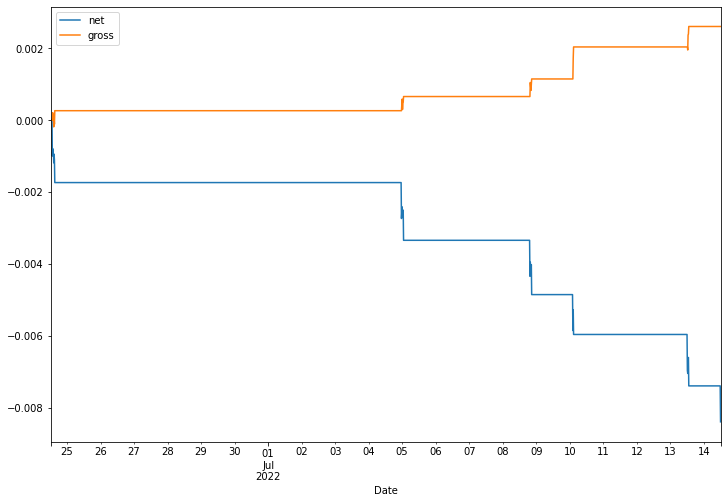

In [47]:
backtester.results['net'].plot(figsize=(12, 8))
backtester.results['gross'].plot(figsize=(12, 8))
plt.legend()
plt.show

In [55]:
dir_name="Binance_Historical_1h_FUTURES_100_days_2022-06-26T10:29:34"
pair=["ENJUSDT_FUTURES", "BAKEUSDT_FUTURES"]
entries = []
for instrument in pair:
  entries.append("%s_%s.csv" % (instrument, "1h"))

df_closings = pd.DataFrame()
for entry in entries:
  instrument = "_".join(entry.split("_")[0:2])
  df = pd.read_csv('raw_data/%s/%s' % (dir_name, entry), index_col="Date", parse_dates=["Date"])
  df = df[["Close"]].copy()
  df.columns = [instrument]
  df["%s_returns" % instrument] = np.log(df[instrument]/df[instrument].shift(1))
  df_closings = pd.concat([df_closings, df], axis=1)
  
      
df_closings.dropna(inplace=True)

In [161]:
df_closings.index[2]

Timestamp('2022-03-18 14:00:00')

In [60]:
df_adfuller = pd.DataFrame()
sample = df_closings.iloc[0:2000].copy()
inst1 = pair[0]
inst2 = pair[1]

def unit_root(b):
  a = np.average(sample[inst2] - b*sample[inst1])
  df_adfuller["fair_value"] = a + b*sample[inst1]
  df_adfuller["diff_fair"] = df_adfuller["fair_value"] - sample[inst2]
  df_adfuller["delta_diff_fair"] = df_adfuller["diff_fair"]/df_adfuller["diff_fair"].shift(1)
  df_adfuller["lag_diff_fair"] = df_adfuller["diff_fair"].shift()
  # LAGS (augmentation)
  df_adfuller["lag1_delta_diff_fair"] = df_adfuller["delta_diff_fair"].shift(1)
  df_adfuller["lag2_delta_diff_fair"] = df_adfuller["delta_diff_fair"].shift(2)
  
  df_adfuller.dropna(inplace=True)
  #OLS(dependent, independent) - add lags to the independent
  reg = sm.OLS(df_adfuller["delta_diff_fair"], df_adfuller[["lag_diff_fair", "lag1_delta_diff_fair", "lag2_delta_diff_fair"]])
  res = reg.fit()
  return res.params[0] / res.bse[0]

# why I use np array & add_constant ??

reg = sm.OLS(np.array(sample[inst2]), sm.add_constant(sample[inst1]))
res = reg.fit()
a0 = res.params[0]
b0 = res.params[1]

unit_root(b0)

res1 = spop.minimize(unit_root, b0, method='Nelder-Mead')
t_opt = res1.fun
b_opt = float(res1.x)
a_opt = np.average(sample[inst2] - b_opt*sample[inst1])

sample["fair_value"] = a_opt + b_opt*sample[inst1]
sample["fair_spread"] = sample["fair_value"] - sample[inst2]
spread_mean = np.mean(sample["fair_spread"])
spread_std = np.std(sample["fair_spread"])
# investigate the curvature of the z_score in comparison to spread
sample["z_score"] = (sample["fair_spread"]-spread_mean)/spread_std

fair_value = a_opt + b_opt*sample[inst1].iloc[1]
spread = fair_value-sample[inst2].iloc[1]


In [61]:
fair_value

0.718851202557804

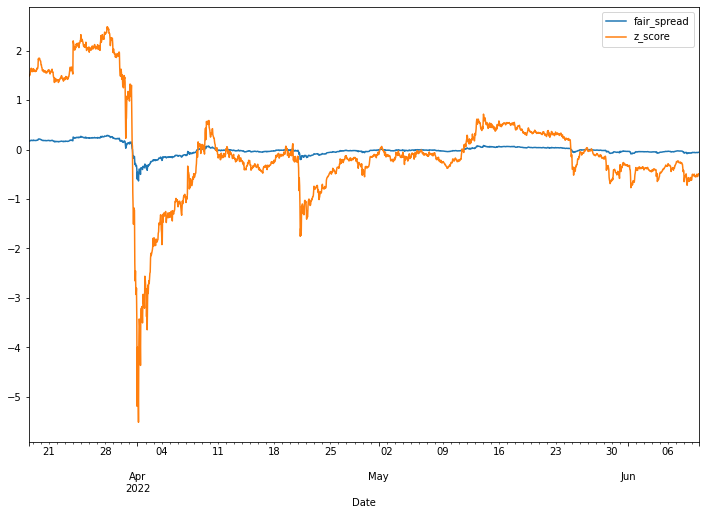

In [39]:
sample.fair_spread.plot(figsize=(12, 8))
sample.z_score.plot()
plt.legend()
plt.show()

In [19]:
signal = 0

if signal == 0:
  print(signal)
  signal = 1
elif signal != 0:
  print(signal)
  signal = 0

0


In [25]:
np.sign(0)

0